# Line tracking

This document is used to implement a line tracking. The line is black on the white background. 

**Note: This document include servos control. When running the code, be careful if there are fragile objects in the range of motion of the robot arm, and keep it away from children.**

# Imports
* [Nanocamera](https://github.com/thehapyone/NanoCamera) - A simple to use camera interface for the Jetson Nano for working with USB, CSI, IP and also RTSP cameras or streaming video in Python
* [Opencv](https://opencv.org/) - Used to operate on images
* [Numpy](https://numpy.org/) - Scientific computing in Python
* [Matplotlib](https://matplotlib.org/) - Visualization with Python
* [jetbot](https://github.com/NVIDIA-AI-IOT/jetbot) - An educational AI robot based on NVIDIA Jetson Nano.
* SCSCtrl - library to control the servos

In [1]:
import nanocamera as nc
import cv2
import numpy as np
import matplotlib.pyplot as plt
from jetbot import Robot
import time
from SCSCtrl import TTLServo

Succeeded to open the port
Succeeded to change the baudrate


## Parameters

In [63]:
# Movement directions
RIGHT = -1
LEFT = 1
STRAIGHT = 0
# Movement parameters
FORWARD_SPEED = 0.14
TURNING_SPEED = 0.21
FORWARD_TIME = 0.012
# Image parameters
CAMERA_SIZE = 200 # CAMERA_SIZE x CAMERA_SIZE - is the size of the frame provided by the camera
ROI_SIZE = CAMERA_SIZE//2 # ROI_SIZE x ROI_SIZE - is the size of the area to analyze
FPS = 15
ERODE_ITER = 2 # Erosion iterations
DILATE_ITER = 3 # Dilation iterations
GAUSSIAN_BLUR_KERNEL_SIZE = (3,3) 
THRESHOLD = 100 # Threshold to filter black color
PRECISION = 7 # has to be odd - while analyzed, the frame is divided into PRECISION x PRECISION cells 
# Motor control
PMC = 0.1 / PRECISION # coefficient for proportional motor control 
SHARP_TURN_COEF = 2.9
SAME_SIDE_TURN_TERM = 1

DEBUG = True

## Objects
* robot - the robot object
* cam - camera object

In [5]:
robot = Robot()
cam = nc.Camera(flip = 0, width = CAMERA_SIZE, height = CAMERA_SIZE, fps = FPS, enforce_fps= True)

## Preparation 

Position the robot on the line so that the line goes between the robot's wheels
Run following cell to put servomotors to their according positions

In [54]:
TTLServo.servoAngleCtrl(1, 0, 1, 150)
TTLServo.servoAngleCtrl(2, 0, 1, 150)
TTLServo.servoAngleCtrl(3, 0, 1, 150)
TTLServo.servoAngleCtrl(4, 0, 1, 150)
TTLServo.servoAngleCtrl(5, 53, 1, 150) #camera should look down

762

## The algorithm

* The ROI from the frame taken by the camera is extracted (the center of the bottom half of the frame) 
* The ROI is denoised, translated to grayscale, eroded and dilated.
* The ROI is devided into PRECISION x PRECISION cells. The amount of pixels representing line in the top row cells and bottom row cells is calculated <br>
![scheme](pic.jpg)<br>
* The indecies of cells with max pixels representing line are used to calculate the direction and duration of the turn.<br>

There are three turns that we analize: 
1. Usual turn - from the one side of the frame to another side of the frame:<br>
![usual](usual.jpg)<br>
2. Sharp turn (when top cells don't have any pixels representing the line):<br>
![sharp](sharp.jpg)<br>
3. Same side turn - when start line position and end line position are on the same side of the frame.<br>
![same_side](same_side.jpg)<br>

In other situations the robot drives straight, accept for the case when no line detected - then the robot is stopped.

In [64]:
def followLine(frame):
    if DEBUG:
        plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        plt.show()
    # Extract ROI - central part of the bottom half of the frame.
    ROI = frame[CAMERA_SIZE // 2 : CAMERA_SIZE, CAMERA_SIZE//4 : CAMERA_SIZE*3//4]
    # Denoise with Gaussian blur
    ROI = cv2.GaussianBlur(ROI, (3,3), 0)
    # To grayscale
    ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
    # Filter black
    _, mask = cv2.threshold(ROI,THRESHOLD,255,cv2.THRESH_BINARY_INV)
    # Erode, this process will remove the relatively 
    # small area in the mask just selected, which can be understood as denoising.
    mask = cv2.erode(mask, None, iterations=ERODE_ITER)
    # dilate, the corrosion process just now will cause the large area to become 
    # smaller and the small area to disappear. This step is to restore the large area to its previous size.
    mask = cv2.dilate(mask, None, iterations=DILATE_ITER)
    # Divide into cells 
    top_row = []
    bottom_row = []
    # get top row cells and bottom row cells
    for i in range(PRECISION):
        ROI_T = mask[: ROI_SIZE//PRECISION , ROI_SIZE*i//PRECISION : ROI_SIZE*(i+1)//PRECISION]
        top_row.append(np.count_nonzero(ROI_T))
        ROI_B = mask[ROI_SIZE*(PRECISION-1)//PRECISION : ROI_SIZE , ROI_SIZE*i//PRECISION : ROI_SIZE*(i+1)//PRECISION]
        bottom_row.append(np.count_nonzero(ROI_B))
    # get index of the cell that contains most pixels that represent the line
    max_idx_top = top_row.index(max(top_row))
    max_idx_bottom = bottom_row.index(max(bottom_row))

    if DEBUG: 
        rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
        plt.imshow(rgb)
        plt.show()
        print("MIU: ", max_idx_top, "MIB: ", max_idx_bottom)
    
    # If there are no pixels that represent line on top row and bottom row, the line is lost of sight 
    if sum(bottom_row) == 0 and sum (top_row) == 0:
        if DEBUG: print ("no line")
        return False

    # If only top cells contain no pixels that represent the line, it's a sharp turn.
    if sum(bottom_row) != 0 and sum (top_row) == 0:
        if DEBUG: print ("lost top")
        # count pixels representing line in left and right halfs of the ROI
        left_side = np.count_nonzero(mask[0:ROI_SIZE , 0:ROI_SIZE//2])
        right_side = np.count_nonzero(mask[0:ROI_SIZE , ROI_SIZE//2 : ROI_SIZE])
        # Explicitly assign the index of the cell containing max line pixels on the top row.
        # We assume that top index is PRECISION far from bottom index,
        # and we also multiply the result with coefficient for sharp turns.
        if  (left_side > right_side): 
            max_idx_top = (max_idx_bottom - PRECISION)*SHARP_TURN_COEF
        else:
            max_idx_top = (max_idx_bottom + PRECISION)*SHARP_TURN_COEF
        
    direction = STRAIGHT # describes where to turn
    center = PRECISION // 2 # the index of center cell of the ROI

    if (max_idx_top <= center and  max_idx_bottom >= center): # turn left
        if DEBUG: print ("left")
        direction = LEFT
        turn = (max_idx_bottom - max_idx_top)
        
    elif (max_idx_top >= center and  max_idx_bottom <= center ): # turn right
        if DEBUG: print ("right")
        direction = RIGHT
        turn = (max_idx_top - max_idx_bottom)
        
    elif (max_idx_top < center and  max_idx_bottom < center  ): # on the left side
        if DEBUG: print ("left side")
        if (max_idx_top <= max_idx_bottom):
            turn = center - max_idx_top + SAME_SIDE_TURN_TERM 
            if DEBUG: print("left")
            direction = LEFT    
            
    elif (max_idx_top > center and  max_idx_bottom > center  ): # on the right side
        print ("right side")
        if (max_idx_top >= max_idx_bottom):
            turn = max_idx_top - center - SAME_SIDE_TURN_TERM
            if DEBUG: print("right")
            direction = RIGHT  

    if (direction): # if not straight, turn:
        robot.left(direction)    
        time.sleep(turn*PMC)

    robot.forward(FORWARD_SPEED)
    time.sleep(FORWARD_TIME)
    return True

## Main loop 

* the image is taken by the camera, 
* the image is sent to the function that controls the robot
* if following line is impossible, the robot is stopped.

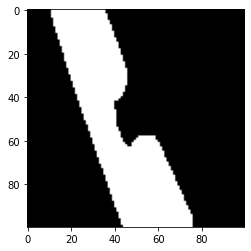

MIU:  1 MIB:  3
left


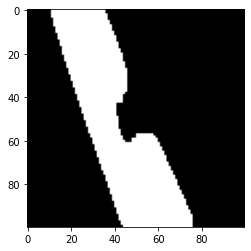

MIU:  1 MIB:  3
left


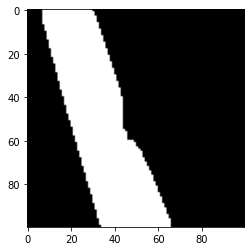

MIU:  1 MIB:  3
left


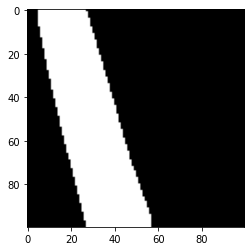

MIU:  1 MIB:  2
left side
left


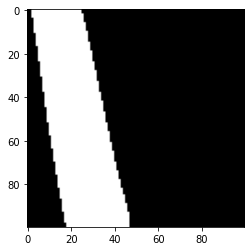

MIU:  1 MIB:  2
left side
left


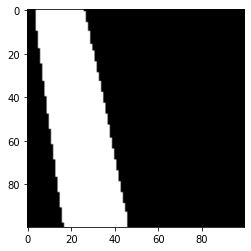

MIU:  1 MIB:  2
left side
left


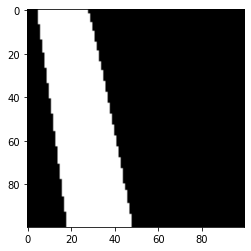

MIU:  1 MIB:  2
left side
left


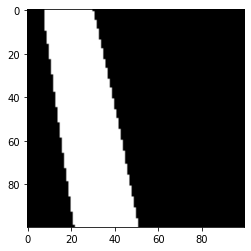

MIU:  1 MIB:  2
left side
left


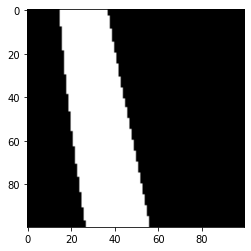

MIU:  1 MIB:  2
left side
left


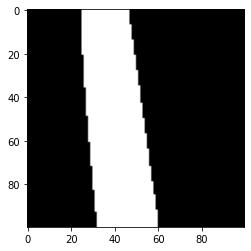

MIU:  2 MIB:  3
left


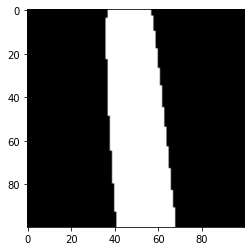

MIU:  3 MIB:  3
left


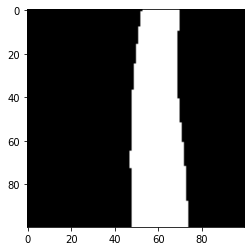

MIU:  4 MIB:  4
right side
right


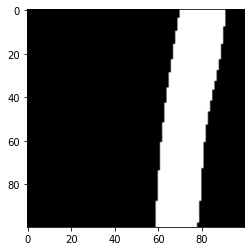

MIU:  5 MIB:  4
right side
right


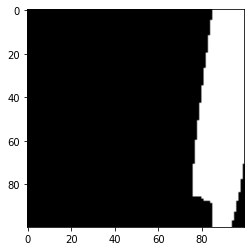

MIU:  6 MIB:  6
right side
right


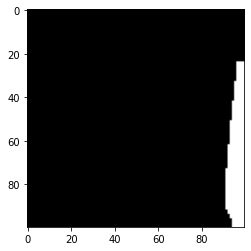

MIU:  0 MIB:  6
lost top
right side
right


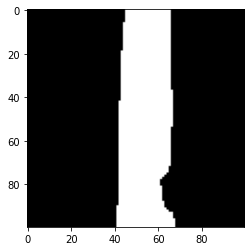

MIU:  3 MIB:  3
left


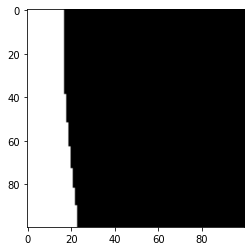

MIU:  0 MIB:  0
left side
left


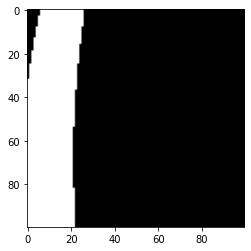

MIU:  1 MIB:  0
left side


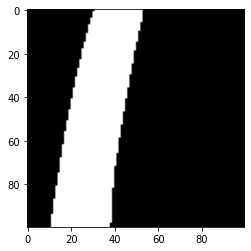

MIU:  2 MIB:  1
left side


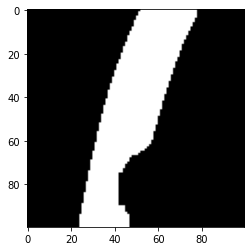

MIU:  4 MIB:  2
right


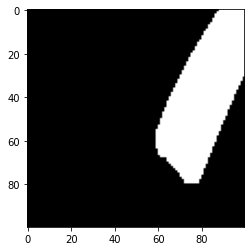

MIU:  6 MIB:  0
right


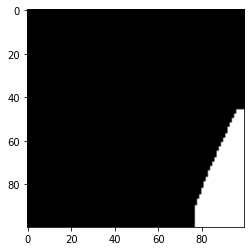

MIU:  0 MIB:  6
lost top
right side
right


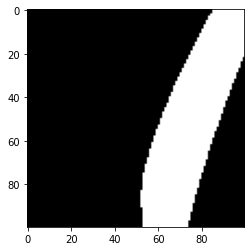

MIU:  6 MIB:  4
right side
right


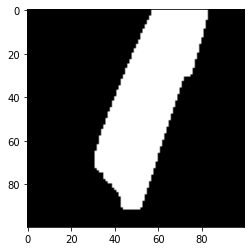

MIU:  4 MIB:  3
right


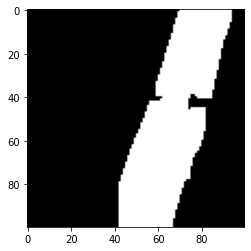

MIU:  5 MIB:  3
right


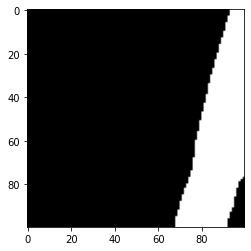

MIU:  6 MIB:  5
right side
right


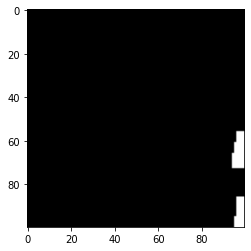

MIU:  0 MIB:  6
lost top
right side
right


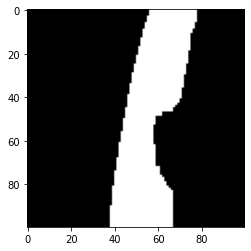

MIU:  4 MIB:  3
right


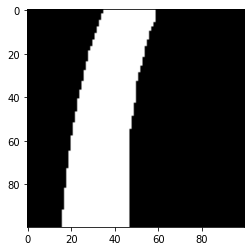

MIU:  3 MIB:  2
right


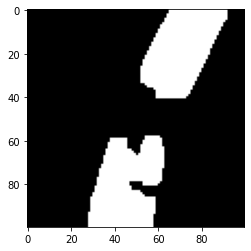

MIU:  5 MIB:  3
right


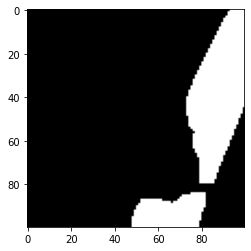

MIU:  6 MIB:  4
right side
right


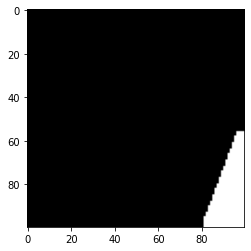

MIU:  0 MIB:  6
lost top
right side
right


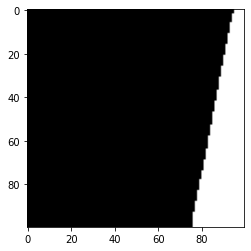

MIU:  6 MIB:  6
right side
right


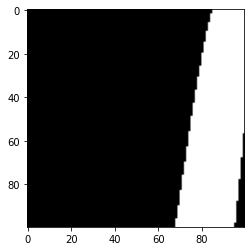

MIU:  6 MIB:  5
right side
right


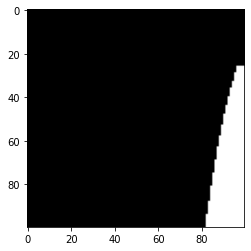

MIU:  0 MIB:  6
lost top
right side
right


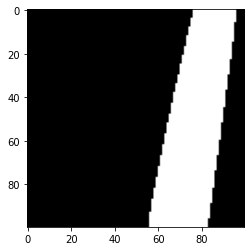

MIU:  6 MIB:  4
right side
right


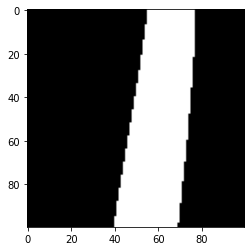

MIU:  4 MIB:  3
right


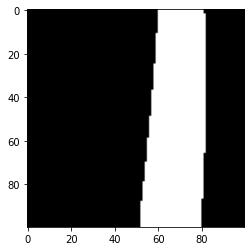

MIU:  4 MIB:  4
right side
right


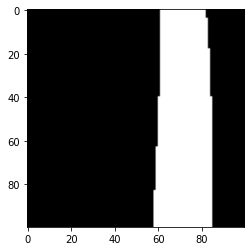

MIU:  5 MIB:  5
right side
right


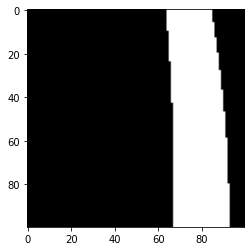

MIU:  5 MIB:  5
right side
right


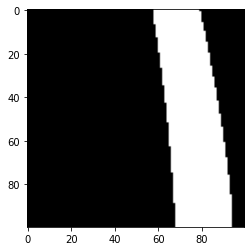

MIU:  4 MIB:  5
right side


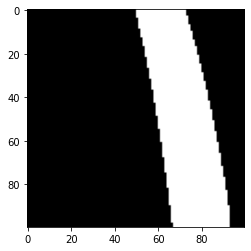

MIU:  4 MIB:  5
right side


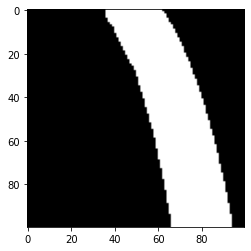

MIU:  3 MIB:  5
left


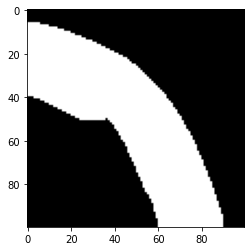

MIU:  0 MIB:  5
left


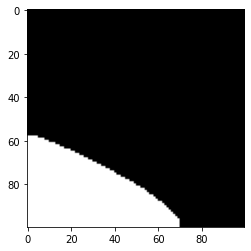

MIU:  0 MIB:  3
lost top
left


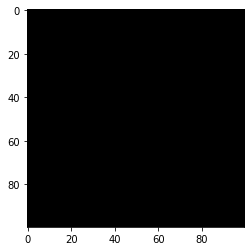

MIU:  0 MIB:  0
no line


In [66]:
while (cam.isReady()):
    frame = cam.read()
    if (not followLine(frame)) :
        robot.stop()
        break

In [46]:
robot.stop()
# close the camera instance
cam.release()

# remove camera object
del cam